In [1]:
# Import necessary libraries
import osmnx as ox
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Polygon
import matplotlib.patches as mpatches

In [2]:
# Create Szolnok County geodataframe and polygon
szolnok_county = ox.geocode_to_gdf('Jász-Nagykun-Szolnok vármegye')
szolnok_county_poly = szolnok_county.geometry.to_list()[0]

In [3]:
# Define OSM tags and their subcategories
tags_with_subcategories = {
    "waterway": ["river", "canal", "stream", "drain"],
    "natural": ["water"]
}

In [4]:
# Download water features based on the tags
water_features = {}
for category, subcategories in tags_with_subcategories.items():
    for subcategory in subcategories:
        features = ox.features_from_polygon(szolnok_county_poly, tags={category: subcategory})
        if not features.empty:
            water_features[subcategory] = features

In [5]:
# Define styles for visualization
feature_styles = {
    "river": {"color": "cornflowerblue", "alpha": 1, "linewidth": 2.5, "label": "River", "zorder": 2}
}

In [6]:
# Define a plotter function
def plot_feature(feature, ax, crs, subcategory):
    # Define default style
    default_style = {"color": "royalblue", "alpha": 1, "linewidth": 0.9, "zorder": 1}
    
    # Use specific style for 'river' or fall back to default
    if subcategory == "river":
        style = feature_styles.get(subcategory, default_style)
    else:
        style = {**default_style, **feature_styles.get(subcategory, {})}

    # Plot the feature
    feature.to_crs(crs).plot(
        ax=ax,
        color=style.get("color"),
        alpha=style.get("alpha"),
        linewidth=style.get("linewidth"),
        zorder=style.get("zorder")
    )

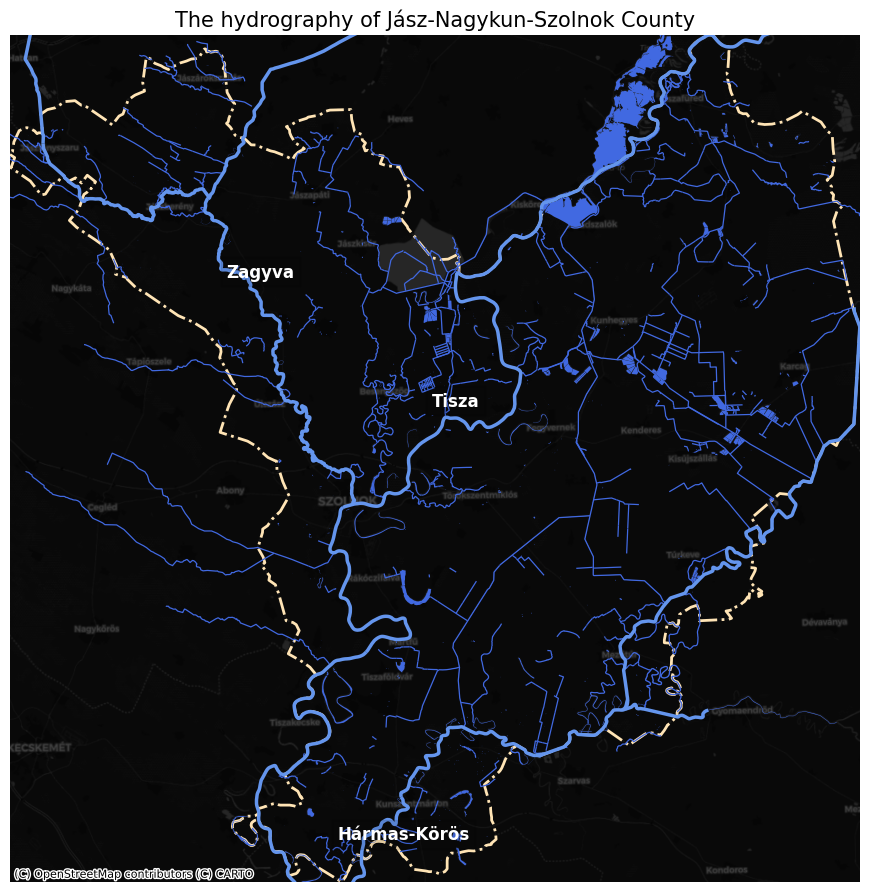

In [7]:
# Plot the map with the water-related features
crs = 23700  # Define the local CRS

f, ax = plt.subplots(1, 1, figsize=(11, 11))

# Plot the boundary
szolnok_county = szolnok_county.to_crs(crs=crs)
szolnok_county.plot(ax=ax, color='none', edgecolor='moccasin', linestyle='-.', linewidth=2)

# Plot each feature
for subcategory, feature_data in water_features.items():
    plot_feature(feature_data, ax, crs, subcategory)


# Add text labels for specific rivers
rivers_to_label = ["Tisza", "Zagyva", "Hármas-Körös"]
if "river" in water_features:
    river_features = water_features["river"].to_crs(crs)  # Convert CRS
    for river_name in rivers_to_label:
        river_rows = river_features[river_features["name"] == river_name]
        if not river_rows.empty:
            # Use the first geometry for labeling
            river_geom = river_rows.iloc[1].geometry
            centroid = river_geom.representative_point()
            ax.text(
                centroid.x-3000, centroid.y+1500, river_name,
                fontsize=12, color="white", weight="bold", zorder=3,
                bbox=dict(facecolor="black", alpha=0.1)
            )

# Add the basemap
ctx.add_basemap(ax, crs=crs, source=ctx.providers.CartoDB.DarkMatter, zoom=10)

# Set axis limits to the Szolnok megye bounds
minx, miny, maxx, maxy = szolnok_county.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Add title and legend
plt.title("The hydrography of Jász-Nagykun-Szolnok County", fontsize=15)
ax.axis("off")

# Show plot
plt.show()